## Parallel Circuits notebook

This notebook describes the `qc_parallelizer` module, its usage in the context of an example, as
well as why the module is useful.

### A. Motivation

In certain quantum computing workloads, it can be the case that there are several smaller\*,
independent\*\* quantum circuits that the user wishes to run, to for instance evaluate results in
some parameter space. Because of the independence, the user might not care about the execution order
or other practicalities related to how the circuits are run.

With existing, commonly-used tooling, executing such a set of circuits can lead to a rather naive
and unoptimized setting, where each circuit is run strictly sequentially. With the introduction
of larger QPU architectures with more qubits, this becomes increasingly wasteful &mdash; especially
if there is overhead in circuit execution, e.g. in uploading circuit data to the control electronics
&mdash; since only a part of the chip is in use at once.

The `qc_parallelizer` module allows the user to transform the list of circuits into larger, combined
circuits, that pack as many user-defined circuits as the QPU can natively process. It provides a
simple set of functions for performing this transformation as well as executing the circuits in a
way that makes parallelization invisible to the user, by returning results from each individual
circuit separately.

Ideally, the user need not make any adjustments in their code &mdash; the module is intended to work
as a direct replacement/addition for `backend.run()`.

*) Low circuit width, where the number of utilized qubits << number of available qubits.<br>
**) Circuits that do not share qubits or depend on results from each other.

### B. Limitations

This technique comes with some limitations and drawbacks:
- **Crosstalk**: a very densely utilized backend will probably contain physically neighboring qubits
  that do not share any operations virtually. However, since physical coupling is fixed, slight
  errors can be introduced between qubits that should not couple. This can be avoided, but it comes
  at a cost of less dense packing, which leads to more circuits, which leads to longer execution
  times.
- **Limited parallelization due to limited connectivity**: two circuits do _not_ fit onto the same
  backend automatically if they collectively use less qubits than what the backend supports. The
  backend must also support coupling between qubits where it is needed, since introducing swap
  operations within circuits has costs that outweigh the benefits (namely, lower execution time) of
  parallelization.

### C. General operation diagram

The diagram below describes the general operation of the parallelizer. The light blue boxes in the
lower half correspond to functions that the `qc_parallelizer` module exposes as its public
interface.

![Parallelizer operation diagram](./parallelizer-full.drawio.png)

### 1. Environment and dependencies

The module is closely tied to Qiskit and depends on it. Consequently, circuits must also be built
with Qiskit's `QuantumCircuit` model. Furthermore, we use IQM's quantum computer backends, as well
as Matplotlib for plots. The full list of dependencies is specified in the project's
`pyproject.toml` file.

With e.g. Conda, one can easily set up an environment with the following commands. Make sure to run
them from the project's root directory.

```bash
conda create --name parallelizer python=3.10 pip
conda activate parallelizer
pip install qc_parallelizer[notebooks]
```

Once this is set up, we can import these packages for usage.

In [1]:
import iqm.qiskit_iqm as iqm
import qiskit
from iqm.qiskit_iqm.fake_backends.fake_adonis import IQMFakeAdonis

print(f"Qiskit version is {qiskit.version.get_version_info()}!")

Qiskit version is 1.2.4!


Below we also import the module itself. This makes the provided functionality accessible under the
`parallelizer` name.

In [2]:
import qc_parallelizer as parallelizer

And lastly, since we are dealing with lists of circuits in this notebook, we also import convenient
helper functions for drawing multiple circuits and histograms into one plot.

In [3]:
from helpers import patch_qiskit_iqm, plot_circuits, plot_histograms

patch_qiskit_iqm()  # ignore (or check docstring for explanation)

### 2. Define example circuits

In the absence of a real-world example, we construct four simple quantum circuits, two with a
single qubit and two with two qubits. The last circuit is more special, in that it uses named
classical registers &mdash; this is to demonstrate how the parallelizer preserves name information
through transformations. We also demonstrate metadata preservation with the `metadata` argument.

In [4]:
def create_ghz_circuit(num_qubits, metadata=None):
    circuit = qiskit.QuantumCircuit(num_qubits, metadata=metadata)
    circuit.h(0)
    for i in range(1, num_qubits):
        circuit.cx(0, i)
    circuit.measure_active()
    return circuit


def create_all_ones_circuit(num_qubits, metadata=None):
    circuit = qiskit.QuantumCircuit(num_qubits, metadata=metadata)
    circuit.x(list(range(num_qubits)))
    circuit.measure_active()
    return circuit


def create_named_reg_circuit(metadata=None):
    qreg = qiskit.QuantumRegister(2)
    cregs = [
        qiskit.ClassicalRegister(1, "bit_one"),
        qiskit.ClassicalRegister(1, "bit_two"),
    ]
    circuit = qiskit.QuantumCircuit(qreg, *cregs, metadata=metadata)
    circuit.h(qreg[0])
    circuit.cx(qreg[0], qreg[1])
    circuit.measure(qreg[0], cregs[0][0])
    circuit.measure(qreg[1], cregs[1][0])
    return circuit


circuits = [
    create_ghz_circuit(num_qubits=1, metadata={"foo": {"bar": "baz"}}),
    create_all_ones_circuit(num_qubits=1),
    create_ghz_circuit(num_qubits=2),
    create_named_reg_circuit(metadata={"tag": "hotel-alpha"}),
]

Now, with the helper function from above, we can visualize these circuits.

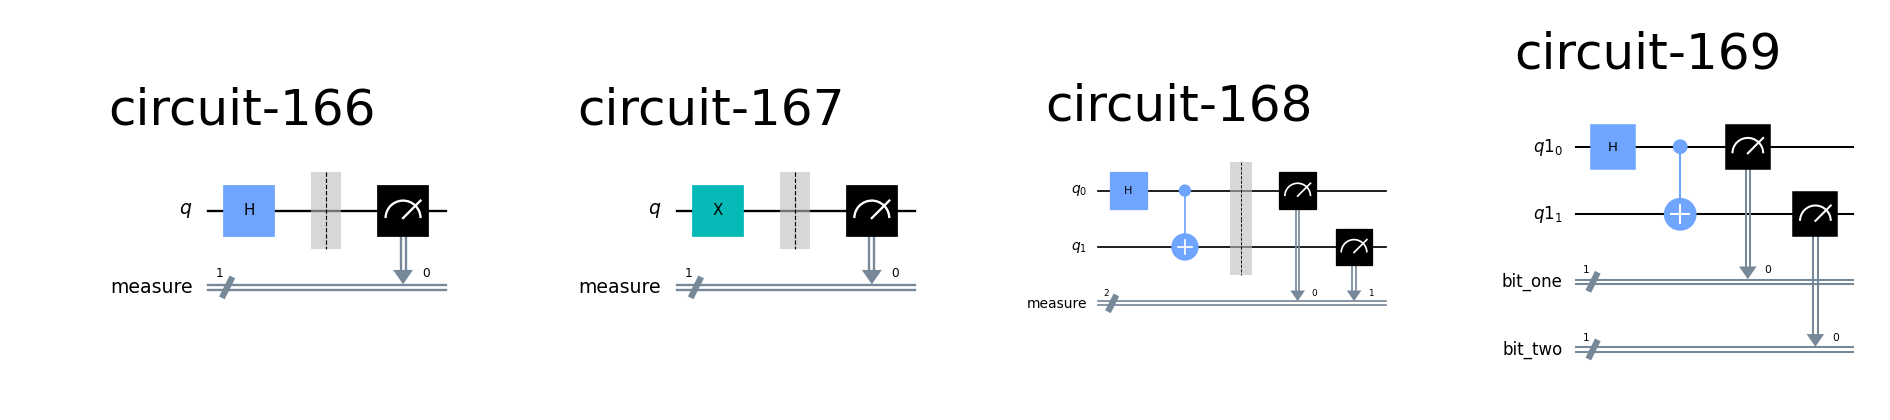

In [5]:
plot_circuits(circuits)

### 3. Define and retrieve backend objects

The parallelizer does not make much sense without information about the quantum computer backend(s)
that we want to work with. We are using `IQMFakeAdonis` to work with a fake IQM backend with five
qubits in a star topology.

In this example, we create two instances of the backend to simulate two separate backends.

You may also use any `BackendV2`-compatible backend, such as the ones returned by `IQMProvider`.
This notebook does not explain how one can find the device URL and access token, though &mdash;
please see other resources for that.

In [6]:
# Use a server backend
# import os
# os.environ["IQM_TOKEN"] = "YOUR_TOKEN_HERE"
# backends = [iqm.IQMProvider("DEVICE_URL_HERE").get_backend()]

# Use local simulator backends
backends = [IQMFakeAdonis(), IQMFakeAdonis()]

print(f"{' + '.join(str(backend.num_qubits) for backend in backends)} qubits available.")

5 + 5 qubits available.


### 4. Circuit layouts

One noteworthy feature of the parallelizer are layout specifications. If specific virtual qubits, be
it one, two, or all qubits in a circuit, need to be placed on predefined physical qubits in the
backend, layout information can be attached to those circuits. The parallelizer will then respect
the given information, and fill in any gaps in the layout(s).

However, because we are using multiple backends, we cannot provide layout information. The reason is
simply that if it were possible, users would have to provide a whole matrix of layouts, one per each
circuit-backend combination. This feature may be implemented in the future, but right now, the
closest alternative is parallelizing circuits in separate sets for each backend.

Just to demonstrate, the code in the cell below would assign a layout to the third circuit.

In [7]:
# circuit_2_layout = {
#     0: 0, # virtual qubit 0 --> QB1
#     1: 2, # virtual qubit 1 --> QB3
# }
# circuits[2] = (circuits[2], circuit_2_layout)

Generally, each circuit in the circuit list must be either
- a `QuantumCircuit` object, in which case the parallelizer chooses a layout for it, or
- a `(QuantumCircuit, Layout | dict | list)` tuple, where the second element is the desired layout.
  The layout can be in any form that Qiskit would accept.

All given circuits need not have a defined layout &mdash; you may pass any desired mixture of
circuits with and without layouts, and the parallelizer will fill in the missing information in a
way that it sees fit.

### 5. Note on transpilation

As indicated by the [operation diagram at the top](#c-general-operation-diagram), the parallelizer
will transpile circuits so that they are compatible with the assigned backends. However,
transpilation is only used to a minimal extent &mdash; converting to the native gate set and
applying light optimization. (Specifically, optimizations that correspond to Qiskit's
`optimization_level = 1` are applied.)

Therefore, if you wish to transpile a circuit with heavier optimizations enabled, please run it
through `qiskit.transpile()` (or your transpiler of choice) first. The parallelizer can work with
both untranspiled and transpiled circuits, and it will prioritize backends that can execute the
circuits with the least number of additional gates &mdash; so, if a circuit has been transpiled for
a specific backend, a backend with that architecture will be used.

### 6. Rearrange the circuits

Now that we have circuits and backends defined, we can rearrange our circuits to be ready for
parallel execution. The function call for that is very simple, _requiring_ only two parameters
(but see below for information on the optional parameters).

In [8]:
parallel_circuits = parallelizer.rearrange(circuits, backends)

> **Note:** calling `parallelizer.rearrange()` in a separate step is not necessary. One may also
  pass the original circuit list directly to `parallelizer.execute()` (see later in this notebook),
  which will perform any required preprocessing automatically.

> **Note #2:** this call is potentially computationally very expensive. The parallelizer must
  transpile circuits so that they fit the given backend(s) and then fit them together optimally. Of
  course, the parallelizer does not intentionally waste CPU cycles, but it is a complex puzzle with
  many pieces. Some thought should thus be given to when/how this function is called when the inputs
  are large.

Now, to see what this did, we can use `.describe()`:

In [9]:
print(parallelizer.describe(parallel_circuits))

2 backends
 - IQMFakeAdonisBackend (5 qubits, 1 host circuit)
   With 1x 2-circuit hosts
 - IQMFakeAdonisBackend (5 qubits, 1 host circuit)
   With 1x 2-circuit hosts


This is informative, but to see _where_ the circuits were placed, we can use another convenient
function:

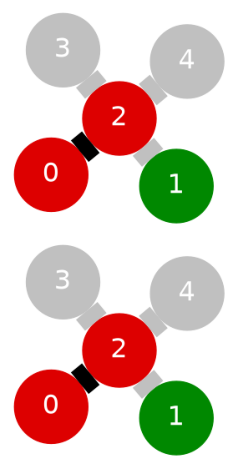

In [10]:
parallelizer.visualization.plot_placements(parallel_circuits)

Here's how to read the figure: rows correspond to different backends, and columns correspond to
execution "moments" on those backends. In this case, there are two backends, and one circuit is
executed on each. Colors represent the circuit that the qubit originally belonged to, so we can see
that two circuits were placed on each backend.

The rearranging step also embeds some metadata into the circuit objects. The user need (and often
must) not modify the metadata &mdash; the parallelizer uses it internally to track which circuits
have been partitioned and information about the original circuits. The original metadata is also
preserved, in case accessing that later is desired.

For those that are curious, the code in the cell below can be used to view said metadata.

In [11]:
# import json
# first_circuit = next(iter(parallel_circuits.values()))[0]
# print(json.dumps(first_circuit.metadata, indent=4))

Additionally, `parallelizer.rearrange()` accepts a few keyword arguments to control circuit
arrangement and parallelization:

| Name | Default | Description |
| -----| ------- | ----------- |
| `packer` | `packers.Defaults.Fast()` | See the next section. |
| `allow_ooe` (allow out-of-order execution) | `True` | If `False`, circuits must be executed strictly in order. A circuit that comes earlier than another circuit is executed latest in parallel with the later circuit. If `True`, the parallelizer is free to reorder circuits to achieve a more optimal packing. |

### 7. Packers

By default, the parallelizer naively places virtual qubits onto the backend wherever they fit and
where they satisfy the circuits' coupling constraints. However, there are some things to consider:
- Crosstalk: If circuits are placed on neighboring qubits, they may physically couple when they
  should not. This applies both to qubits within a single circuit, and qubits from different
  circuits.
- Optimization: Depending on the circuits, there may be exponentially many ways to place a set of
  circuits onto a backend. Some are denser than others, and there may be cases where execution time
  can be dramatically reduced by picking the packing wisely.

Both of these are dealt with and controlled by _packers_. In summary, a packer is an object passed
to the parallelizer that is responsible for the following:
- Given a backend and some circuits that have already been placed on it, determining which qubits
  can (not) be used for the following circuits.
- Evaluating packings, to determine which of several candidates is best.
- Determining layouts for circuits, considering defined layouts for the circuits and circuits that
  have already been placed on the backend.

The user can implement their own packers by subclassing `packers.PackerBase`. The parallelizer
also provides a few built-in packers, with two sensible defaults: `packers.Defaults.Fast` and
`packers.Defaults.Optimal`.

For more information on packers, see the `packers` module, or read the
[notebook](./circuit-packers.ipynb).

### 8. Execute the circuits

Now that we have everything that we need, we may submit the circuit(s) for execution. This is done
with another simple function call. If you wish to pass arguments to the underlying call to
`backend.run()`, you may pass a dictionary in an argument called `run_args`. Likewise, if you
skipped calling `parallelizer.rearrange()`, you can pass arguments to that in `rearrange_args`.

Note that **this won't block** for results until we call `parallel_job.results()` later.

In [12]:
parallel_job = parallelizer.execute(parallel_circuits)

We might have to wait a bit &mdash; one job with the corresponding backend's assigned circuits has
been sent to each backend.

Eventually, we can fetch and visualize the results with the other helper function from above. We can
also verify that the circuit order as well as original metadata is indeed preserved.

Job IDs:
 - 55a2dad5-338c-4db8-8ec5-1d314e77d159
 - 460991fe-812e-49cd-aa61-1a0546590aad
Metadata #0: {'foo': {'bar': 'baz'}}
Metadata #1: {}
Metadata #2: {}
Metadata #3: {'tag': 'hotel-alpha'}


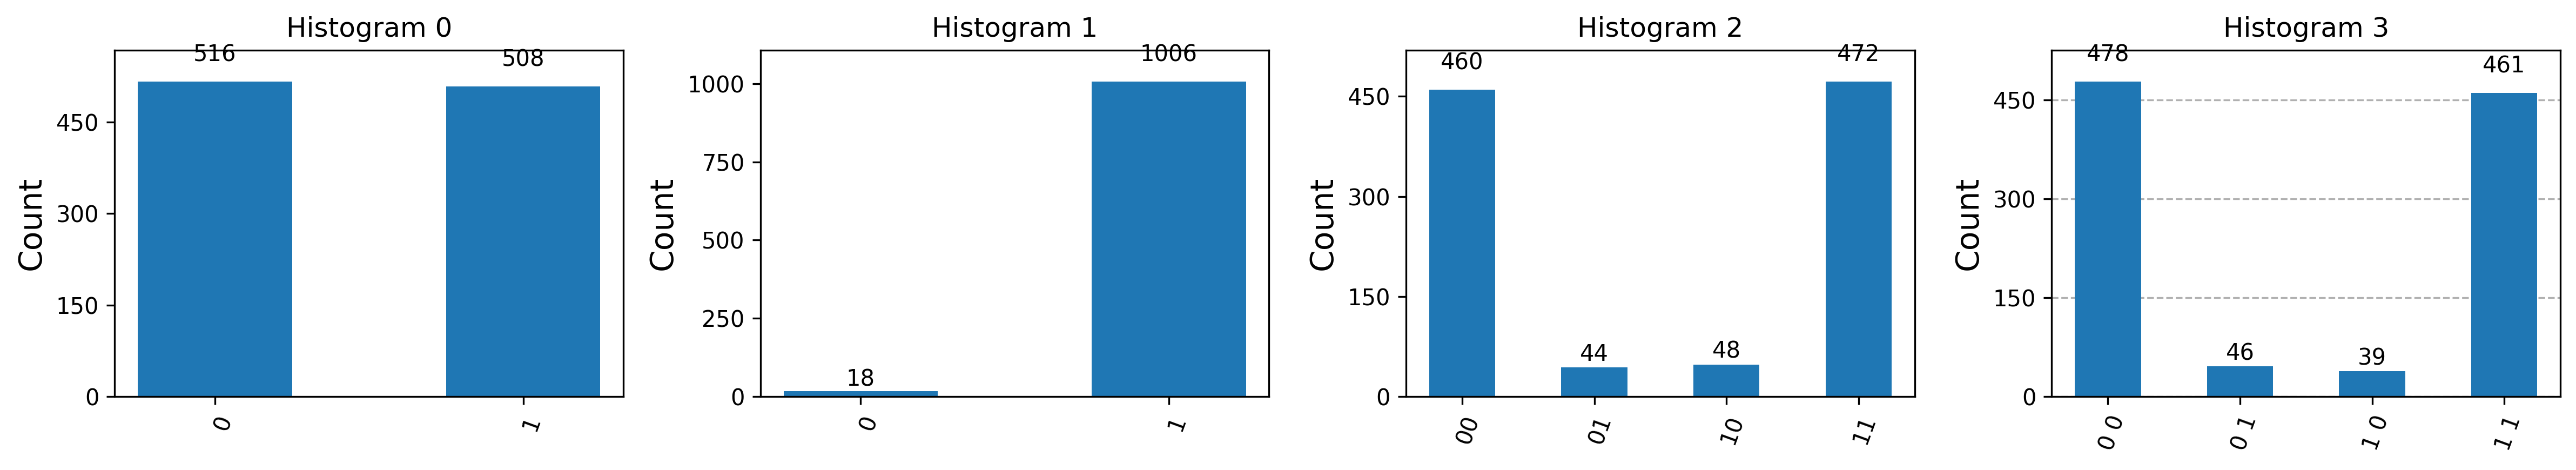

In [13]:
results = parallel_job.results()  # This will block.

print("Job IDs:")
for job_id in parallel_job.job_id():
    print(f" - {job_id}")

for i, result in enumerate(results):
    print(f"Metadata #{i}:", result.header.metadata)

plot_histograms([result.get_counts() for result in results], figsize=(16, 3))

### This concludes the Parallel Circuits notebook!

Consider what happened under the hood: our four example circuits were combined into two host
circuits and then executed in parallel on two separate backends. However, as a user, you do not
deal with any of this directly, and can work with circuits and results in a sequential manner.